# Problem: Optimization of Variational Quantum Algorithms

Recently, a big effort by the quantum computing community has been devoted to the study of variational quantum algorithms (VQAs) which leverage quantum circuits with fixed shape and tunable parameters. The idea is similar to classical neural networks, where the weights of the network are optimized during training. Similarly, once the shape of the variational quantum circuit is chosen — something that is very difficult and sensitive to the particular task at hand — its tunable parameters are optimized iteratively by minimizing a cost (or loss) function, which measures how good the quantum algorithm is performing.

A major challenge for VQAs relates to the optimization of tunable parameters, which was shown to be a very hard task. Parameter initialization plays a key role in this scenario, since initializing the parameters in the proximity of an optimal solution leads to faster convergence and better results. Thus, a good initialization strategy is crucial to promote the convergence of local optimizers to local extrema and to select reasonably good local minima. By local optimizer, we mean a procedure that moves from one solution to another by small (local) changes in parameter space. These are opposed to global search methods, which take into account large sections of parameter space to propose a new solution.

# Solution: Classical Recurrent Neural Networks

By building on results from the meta-learning literature in machine learning, authors in 1 propose to use a Recurrent Neural Network (RNN) as a black-box controller to optimize the parameters of variational quantum algorithms, as shown in the figure below. The cost function used is the expectation value  
⟨
H
⟩
θ
=
⟨
ψ
θ
|
H
|
ψ
θ
⟩
  of a Hamiltonian  
H
  with respect to the parametrized state  
|
ψ
θ
⟩
  evolved by applying the variational quantum circuit to the zero state  
|
00
⋯
0
⟩
 .

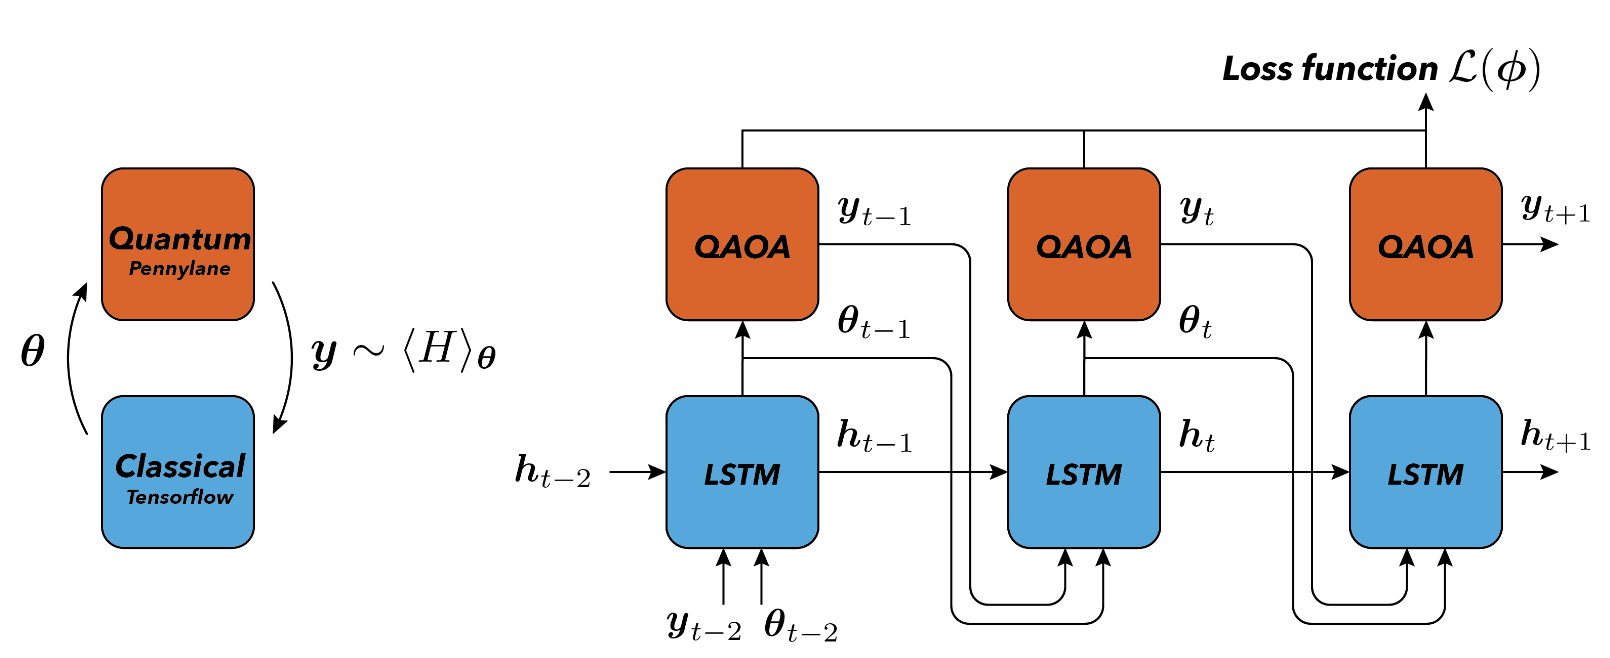

Given parameters  θt−1 of the variational quantum circuit, the cost function  yt−1, and the hidden state of the classical network  ht−1 at the previous time step, the recurrent neural network proposes a new guess for the parameters  θt, which are then fed into the quantum computer to evaluate the cost function  yt. By repeating this cycle a few times, and by training the weights of the recurrent neural network to minimize the loss function  yt, a good initialization heuristic is found for the parameters  θ of the variational quantum circuit.

At a given iteration, the RNN receives as input the previous cost function  yt evaluated on the quantum computer,where yt is the estimate of  ⟨H⟩t, as well as the parameters  θt for which the variational circuit was evaluated. The RNN at this time step also receives information stored in its internal hidden state from the previous time step  ht. The RNN itself has trainable parameters  ϕ, and hence it applies the parametrized mapping:

ht+1,θt+1=RNNϕ(ht,θt,yt),
 
which generates a new suggestion for the variational parameters as well as a new internal state. Upon training the weights  ϕ, the RNN eventually learns a good heuristic to suggest optimal parameters for the quantum circuit.

Thus, by training on a dataset of graphs, the RNN can subsequently be used to provide suggestions for starting points on new graphs! We are not directly optimizing the variational parameters of the quantum circuit, but instead, we let the RNN figure out how to do that. In this sense, we are learning (training the RNN) how to learn (how to optimize a variational quantum circuit).

#### VQAs in focus: QAOA for MaxCut

There are multiple VQAs for which this hybrid training routine could be used, some of them directly analyzed in 1. In the following, we focus on one such example, the Quantum Approximate Optimization Algorithm (QAOA) for solving the MaxCut problem 4. Thus, referring to the picture above, the shape of the variational circuit is the one dictated by the QAOA ansatz, and such a quantum circuit is used to evaluate the cost Hamiltonian  H of the MaxCut problem. Check out this great tutorial on how to use QAOA for solving graph problems: https://pennylane.ai/qml/demos/tutorial_qaoa_intro.html

#### Importing the required packages

In [63]:
# Quantum Machine Learning
import pennylane as qml
from pennylane import qaoa

In [64]:
# Classical Machine Learning
import tensorflow as tf

In [65]:
# Generation of graphs
import networkx as nx

In [66]:
# Standard Python libraries
import numpy as np
import matplotlib.pyplot as plt
import random

from silence_tensorflow import silence_tensorflow
silence_tensorflow()

In [67]:
# Fix the seed for reproducibility, which affects all random functions in this demo
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

### Generation of training data: graphs

The first step is to gather or create a good dataset that will be used to train the model and test its performance. In our case, we are analyzing MaxCut, which deals with the problem of finding a good binary partition of nodes in a graph such that the number of edges cut by such a separation is maximized. We start by generating some random graphs  Gn,p
where:

    n  is the number of nodes in each graph,
    p  is the probability of having an edge between two nodes.

In [68]:
def generate_graphs(n_graphs, n_nodes, p_edge):
    """Generate a list contaning random graphs generated by Networkx."""
    datapoints = []
    for _ in range(n_graphs):
        random_graph = nx.gnp_random_graph(n_nodes, p=p_edge)
        datapoints.append(random_graph)
    return datapoints

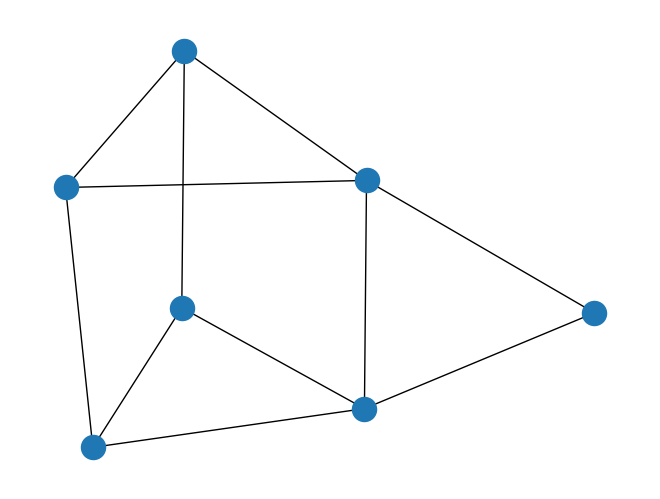

In [69]:
# Define parameters of the graphs
n_graphs = 20
n_nodes = 7
p_edge = 3.0 / n_nodes
graphs = generate_graphs(n_graphs, n_nodes, p_edge)

nx.draw(graphs[0])

### Variational Quantum Circuit: QAOA

Now that we have a dataset, we move on by creating the QAOA quantum circuits using PennyLane’s built-in sub-packages. In particular, using PennyLane’s qaoa module, we will able to create fully functioning quantum circuits for the MaxCut problem, with very few lines of code.

In [70]:
def qaoa_from_graph(graph, n_layers=1):
    """Uses QAOA to create a cost Hamiltonian for the MaxCut problem."""
    
    # Number of qubits (wires) equal to the number of nodes in the graph
    wires = range(len(graph.nodes))
    
    # Defines the structure of the cost and mixer subcircuits for the MaxCut problem
    cost_h, mixer_h = qaoa.maxcut(graph)
    
    # Define a layer of the QAOA ansatz from the cost and mixer Hamiltonians
    def qaoa_layer(gamma, alpha):
        qaoa.cost_layer(gamma, cost_h)
        qaoa.mixer_layer(alpha, mixer_h)
        
    # Creates the actual quantum circuit for the QAOA algorithm
    def circuit(params, **kwargs):
        for w in wires:
            qml.Hadamard(wires=w)
        qml.layer(qaoa_layer, n_layers, params[0], params[1])
        return qml.expval(cost_h)
    
    # Evaluate the cost Hamiltonian
    def hamiltonian(params, **kwargs):
        """Evaluate the cost Hamiltonian, given the angles and the graph."""
        
        # We set the default.qubit.tf device for seamless integration with TensorFlow
        dev = qml.device("default.qubit.tf", wires=len(graph.nodes))
        
        # This qnode evaluates the expectation value of the cost hamiltonian operator
        cost = qml.QNode(circuit, dev, interface="tf", diff_method="backprop")
        
        return cost(params)

    return hamiltonian

Before continuing, let’s see how to use these functions.

In [71]:
# Create an instance of a QAOA circuit given a graph
cost = qaoa_from_graph(graph=graphs[0], n_layers=1)

# Since we use only one layer in QAOA, parama have the shape 1 x 2,
# in the form [[alpha, gamma]].
x = tf.Variable([[0.5], [0.5]], dtype=tf.float32)

# Evaluate th QAOA instance just creates with some angles.
print(cost(x))

tf.Tensor(-3.1932679572555784, shape=(), dtype=float64)


### Recurrent Neural Network: LSTM

So far, we have defined the machinery which lets us build the QAOA algorithm for solving the MaxCut problem. Now we wish to implement the Recurrent Neural Network architecture explained previously. As proposed in the original paper, we will build a custom model of a Long-Short Term Memory (LSTM) network, capable of handling the hybrid data passing between classical and quantum procedures. For this task, we will use Keras and TensorFlow.

First of all, let’s define the elemental building block of the model, an LSTM cell (see TensorFlow documentation for further details).

In [72]:
# Set the number of layers in the QAOA ansatz.
# The higher the better in terms of performance, but it also gets more
# computationally expensive. For simplicity, we stick to the single layer case.
n_layers = 1

# Define a single LSTM cell.
# The cell has two units per layer since each layer in the QAOA ansatz
# makes use of two parameters.
cell = tf.keras.layers.LSTMCell(2 * n_layers)

Using the qaoa_from_graph function, we create a list graph_cost_list containing the cost functions of a set of graphs. You can see this as a preprocessing step of the data.

In [73]:
# We create the QAOA MaxCut cost functions of some graphs
graph_cost_list = [qaoa_from_graph(g) for g in graphs]

At this stage, we seek to reproduce the recurrent behavior depicted in the picture above, outlining the functioning of an RNN as a black-box optimizer. We do so by defining two functions:

    rnn_iteration: accounts for the computations happening on a single time step in the figure. It performs the calculation inside the CPU and evaluates the quantum circuit on the QPU to obtain the loss function for the current parameters.

    recurrent_loop: as the name suggests, it accounts for the creation of the recurrent loop of the model. In particular, it makes consecutive calls to the rnn_iteration function, where the outputs of a previous call are fed as inputs of the next call.

In [74]:
def rnn_iteration(inputs, graph_cost, n_layers=1):
    """Perform a single time step in the computational graph of the custom RNN."""
    
    # Unpack the input list containing the previous cost, parameters,
    # and hidden states (detnoted as 'h' and 'c')
    prev_cost = inputs[0]
    prev_params = inputs[1]
    prev_h = inputs[2]
    prev_c = inputs[3]
    
    # Concatenate the previous parameters and previous cost to create new input
    new_input = tf.keras.layers.concatenate([prev_cost, prev_params])
    
    # Call the LSTM cell, which putputs new values for the parameters along
    # with new internal states h and c
    new_params, [new_h, new_c] = cell(new_input, states=[prev_h, prev_c])
    
    # Reshape the parameters to correctly match those expected by PennyLane
    _params = tf.reshape(new_params, shape=(2, n_layers))
    
    # Evaluate the cost using new angles
    _cost = graph_cost(_params)
    print(f" Evaluate the cost using new angles: {_cost}")
        
    # Reshape to be consistent with other tensors
    new_cost = tf.reshape(tf.cast(_cost, dtype=tf.float32), shape=(1, 1))
    
    return [new_cost, new_params, new_h, new_c]


def recurrent_loop(graph_cost, n_layers=1, intermediate_steps=False):
    """Creates the recurrent loop for the Recurrent Neural Network."""
    
    # Initialize starting all inputs (cost, parameters, hidden states) as zeros.
    initial_cost = tf.zeros(shape=(1, 1))
    initial_params = tf.zeros(shape=(1, 2 * n_layers))
    initial_h = tf.zeros(shape=(1, 2 * n_layers))
    initial_c = tf.zeros(shape=(1, 2 * n_layers))
    
    # We perform five consecutive calls to 'rnn_iteration', thus creating the
    # recurrent loop. More iterations lead to better results, at the cost of
    # more computationally intensive simulations.
    out0 = rnn_iteration([initial_cost, initial_params, initial_h, initial_c], graph_cost)
    out1 = rnn_iteration(out0, graph_cost)
    out2 = rnn_iteration(out1, graph_cost)
    out3 = rnn_iteration(out2, graph_cost)
    out4 = rnn_iteration(out3, graph_cost)    
    
    # This cost function takes into account the cost from all iterations,
    # but using different weights.
    loss = tf.keras.layers.average([0.1 * out0[0], 0.2 * out1[0], 0.3 * out2[0], 0.4 * out3[0], 0.5 * out4[0]])
    
    if intermediate_steps:
        return [out0[1], out1[1], out2[1], out3[1], out4[1], loss]
    else:
        return loss

### The cost function

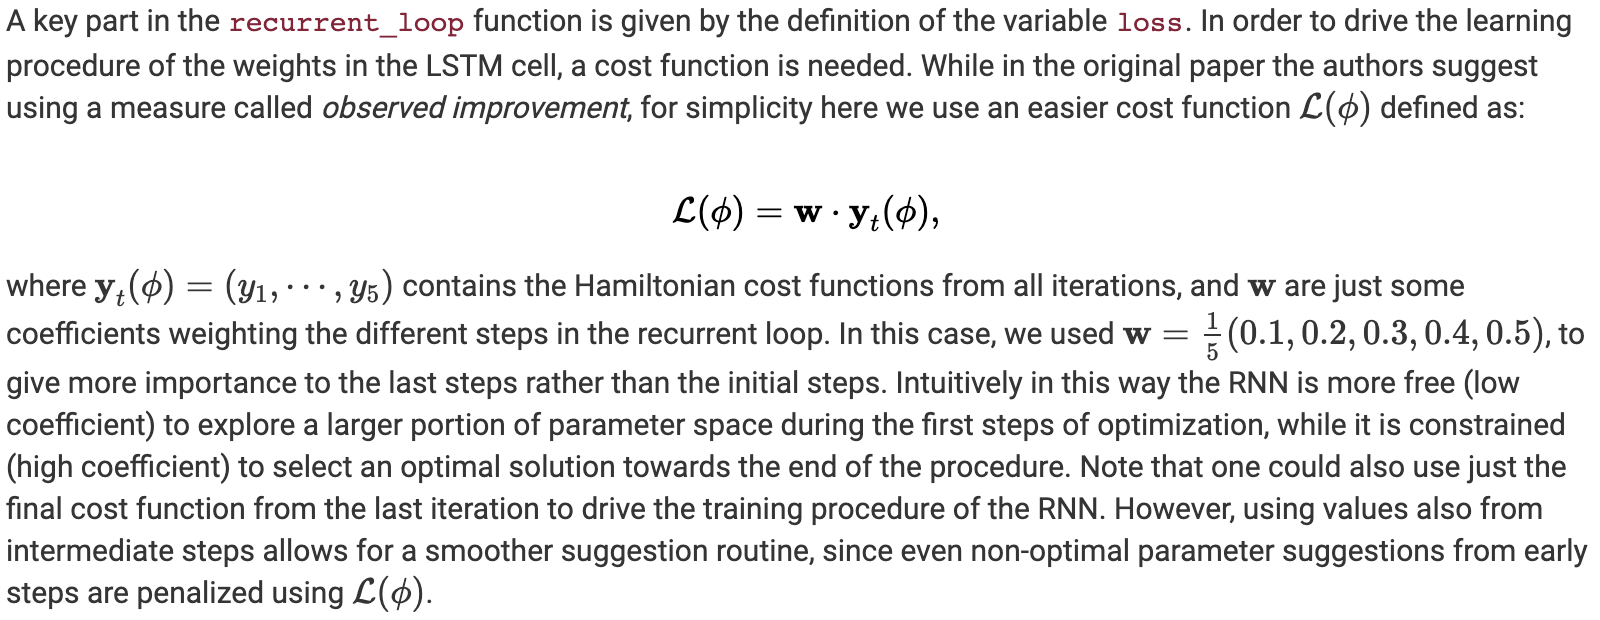

### Training

Now all the cards are on the table and we just need to prepare a training routine and then run it!

First of all, let’s wrap a single gradient descent step inside a custom function train_step.

In [75]:
def train_step(graph_cost):
    """Single optimization step in the training precedure."""
    
    with tf.GradientTape() as tape:
        # Evalustes the cost function        
        loss = recurrent_loop(graph_cost)
        
    # Evaluates gradients, cell is the LSTM cell defined previously
    grads = tape.gradient(loss, cell.trainable_weights)
    
    #Apply gradients and update the weights of the LSTM cell
    opt.apply_gradients(zip(grads, cell.trainable_weights))
    return loss

We are now ready to start the training. In particular, we will perform a stochastic gradient descent in the parameter space of the weights of the LSTM cell. For each graph in the training set, we evaluate gradients and update the weights accordingly. Then, we repeat this procedure for multiple times (epochs).

In [76]:
# Select an optimizer
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.1)

# Set the number of training epochs
epochs = 5

for epoch in range(epochs):
    print(f"Eposh {epoch+1}")
    total_loss = np.array([])
    for i, graph_cost in enumerate(graph_cost_list):
        loss = train_step(graph_cost)
        total_loss = np.append(total_loss, loss.numpy())
        # Log every 5 batches.
        if i % 5 == 0:
            print(f" > Graph {i + 1}/{len(graph_cost_list)} - Loss: {loss[0][0]}")
    print(f" >> Mean Loss during epoch: {np.mean(total_loss)}")

Eposh 1
 Evaluate the cost using new angles: -5.499999999999981
 Evaluate the cost using new angles: -5.518692577373903
 Evaluate the cost using new angles: -5.5243519689596
 Evaluate the cost using new angles: -5.524890489768268
 Evaluate the cost using new angles: -5.524955157346361
 > Graph 1/20 - Loss: -1.6566956043243408
 Evaluate the cost using new angles: -3.5102891860797607
 Evaluate the cost using new angles: -3.7201992707056197
 Evaluate the cost using new angles: -3.8174496786331344
 Evaluate the cost using new angles: -3.820666028016561
 Evaluate the cost using new angles: -3.819628897842873
 Evaluate the cost using new angles: -6.568625835324891
 Evaluate the cost using new angles: -6.734185211494887
 Evaluate the cost using new angles: -6.794246983741064
 Evaluate the cost using new angles: -6.795777632570242
 Evaluate the cost using new angles: -6.795636321223369
 Evaluate the cost using new angles: -5.129320642346156
 Evaluate the cost using new angles: -5.9667090481443

 Evaluate the cost using new angles: -6.053457962572515
 Evaluate the cost using new angles: -6.259466330797256
 Evaluate the cost using new angles: -6.223128521570259
 Evaluate the cost using new angles: -6.222053981914559
 Evaluate the cost using new angles: -6.221779307473163
 Evaluate the cost using new angles: -4.583139801914919
 Evaluate the cost using new angles: -4.635664770060304
 Evaluate the cost using new angles: -4.649736854016122
 Evaluate the cost using new angles: -4.6507785274945475
 Evaluate the cost using new angles: -4.650994552562497
 > Graph 11/20 - Loss: -1.393235445022583
 Evaluate the cost using new angles: -6.359651321341497
 Evaluate the cost using new angles: -6.350120591490853
 Evaluate the cost using new angles: -6.343715145263136
 Evaluate the cost using new angles: -6.341528554867541
 Evaluate the cost using new angles: -6.3413816755911805
 Evaluate the cost using new angles: -5.35305892836804
 Evaluate the cost using new angles: -5.509486494607027
 Eval

 Evaluate the cost using new angles: -7.144358123254878
 Evaluate the cost using new angles: -7.143246053991907
 Evaluate the cost using new angles: -7.140756603645549
 Evaluate the cost using new angles: -7.140912681826187
 Evaluate the cost using new angles: -7.140825630044729
 Evaluate the cost using new angles: -5.815788064560707
 Evaluate the cost using new angles: -5.789442856850294
 Evaluate the cost using new angles: -5.793966741457084
 Evaluate the cost using new angles: -5.795431905123435
 Evaluate the cost using new angles: -5.795325529992893
 >> Mean Loss during epoch: -1.8349555730819702
Eposh 4
 Evaluate the cost using new angles: -7.144497569331859
 Evaluate the cost using new angles: -7.1441908535317475
 Evaluate the cost using new angles: -7.143682454462258
 Evaluate the cost using new angles: -7.144182729046992
 Evaluate the cost using new angles: -7.144122462805886
 > Graph 1/20 - Loss: -2.1432254314422607
 Evaluate the cost using new angles: -4.615690666543484
 Eval

 Evaluate the cost using new angles: -5.9556265035523985
 Evaluate the cost using new angles: -5.939305026288741
 Evaluate the cost using new angles: -5.946735927710808
 Evaluate the cost using new angles: -5.94554786047304
 Evaluate the cost using new angles: -5.9456302438786945
 Evaluate the cost using new angles: -6.9098433744859875
 Evaluate the cost using new angles: -6.926126271909183
 Evaluate the cost using new angles: -6.92090867089802
 Evaluate the cost using new angles: -6.920936515419019
 Evaluate the cost using new angles: -6.920947036139779
 Evaluate the cost using new angles: -6.297836284935856
 Evaluate the cost using new angles: -6.286998198674356
 Evaluate the cost using new angles: -6.2831256440833485
 Evaluate the cost using new angles: -6.284754333851801
 Evaluate the cost using new angles: -6.28470256383612
 Evaluate the cost using new angles: -6.242721887707546
 Evaluate the cost using new angles: -6.259201231621562
 Evaluate the cost using new angles: -6.2637329

### Results

Let’s see how to use the optimized RNN as an initializer for the angles in the QAOA algorithm.

First, we pick a new graph, not present in the training dataset:

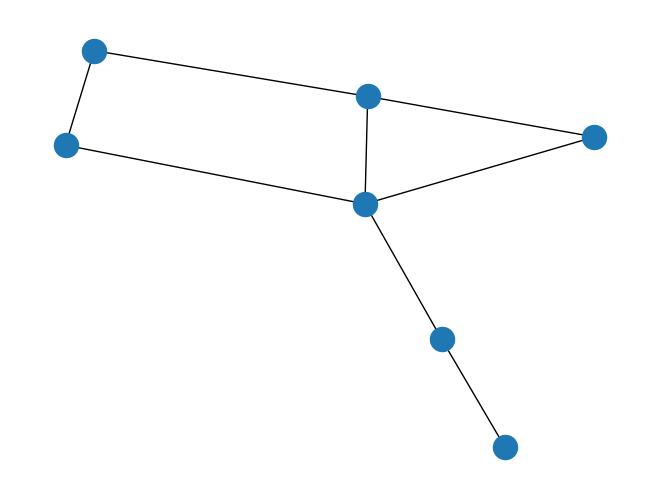

In [77]:
new_graph = nx.gnp_random_graph(7, p=3 / 7)
new_cost = qaoa_from_graph(new_graph)

nx.draw(new_graph)

Then we apply the trained RNN to this new graph, saving intermediate results coming from all the recurrent iterations in the network.

In [78]:
# Apply the RNN (be sure that training was performed)
res = recurrent_loop(new_cost, intermediate_steps=True)

# Extract all angle suggestions
start_zeros = tf.zeros(shape=(2 * n_layers, 1))
guess_0 = res[0]
guess_1 = res[1]
guess_2 = res[2]
guess_3 = res[3]
guess_4 = res[4]
final_loss = res[5]

# Wrap them into a list
guesses = [start_zeros, guess_0, guess_1, guess_2, guess_3, guess_4]

# Losses from the hybrid LSTM model
lstm_losses = [new_cost(tf.reshape(guess, shape=(2, n_layers))) for guess in guesses]

 Evaluate the cost using new angles: -5.50270416800892
 Evaluate the cost using new angles: -5.524862650410107
 Evaluate the cost using new angles: -5.534198405049007
 Evaluate the cost using new angles: -5.5339618357128515
 Evaluate the cost using new angles: -5.53401875136798


### Plot of the loss function

We can plot these losses to see how well the RNN proposes new guesses for the parameters.

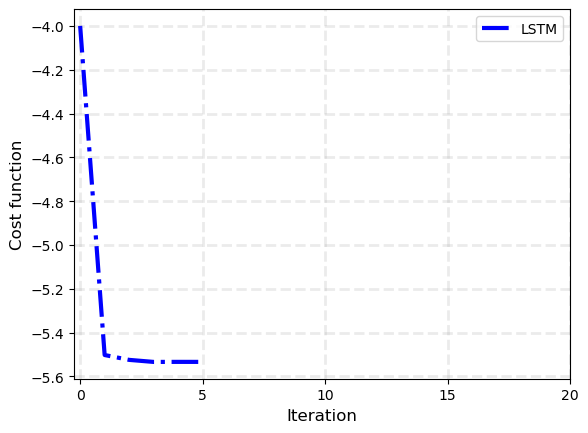

In [82]:
fig, ax = plt.subplots()

plt.plot(lstm_losses, color="blue", lw=3, ls="-.", label="LSTM")

plt.grid(ls="--", lw=2, alpha=0.25)
plt.ylabel("Cost function", fontsize=12)
plt.xlabel("Iteration", fontsize=12)
plt.legend()
ax.set_xticks([0, 5, 10, 15, 20]);
plt.show()

That’s remarkable! The RNN learned to propose new parameters such that the MaxCut cost is minimized very rapidly: in just a few iterations the loss reaches a minimum. Actually, it takes just a single step for the LSTM to find a very good minimum. In fact, due to the recurrent loop, the loss in each time step is directly dependent on the previous ones, with the first iteration thus having a lot of influence on the loss function defined above. Changing the loss function, for example giving less importance to initial steps and just focusing on the last one, leads to different optimization behaviors, but with the same final results.

### Comparison with standard Stochastic Gradient Descent (SGD)

How well does this method compare with standard optimization techniques, for example, leveraging Stochastic Gradient Descent (SGD) to optimize the parameters in the QAOA?

Let’s check it out.

In [84]:
# Parameters are randomly initialized
x = tf.Variable(np.random.rand(2, 1))

# We set the optimizer to be a Stochastic Gradient Descent
opt = tf.keras.optimizers.legacy.SGD(learning_rate=0.01)
step = 15

# Training process
steps = []
sdg_losses = []

for _ in range(step):
    with tf.GradientTape() as tape:
        loss = new_cost(x)
        
    steps.append(x)
    sdg_losses.append(loss)
    
    gradients = tape.gradient(loss, [x])
    opt.apply_gradients(zip(gradients, [x]))
    print(f"Step {_+1} - Loss = {loss}")
    
print(f"Final cost function: {new_cost(x).numpy()}\nOptimized angles: {x.numpy()}")
    

Step 1 - Loss = -2.9005859192819017
Step 2 - Loss = -3.2428082128700773
Step 3 - Loss = -3.6584682283189687
Step 4 - Loss = -4.109306373394999
Step 5 - Loss = -4.53691855977044
Step 6 - Loss = -4.888930274337314
Step 7 - Loss = -5.143084123704181
Step 8 - Loss = -5.308154579579307
Step 9 - Loss = -5.407639307515325
Step 10 - Loss = -5.464871414150867
Step 11 - Loss = -5.496998478405129
Step 12 - Loss = -5.514887496987823
Step 13 - Loss = -5.524900408703266
Step 14 - Loss = -5.530604949850938
Step 15 - Loss = -5.533956376921273
Final cost function: -5.536013954204854
Optimized angles: [[ 0.63883613]
 [-0.35703791]]


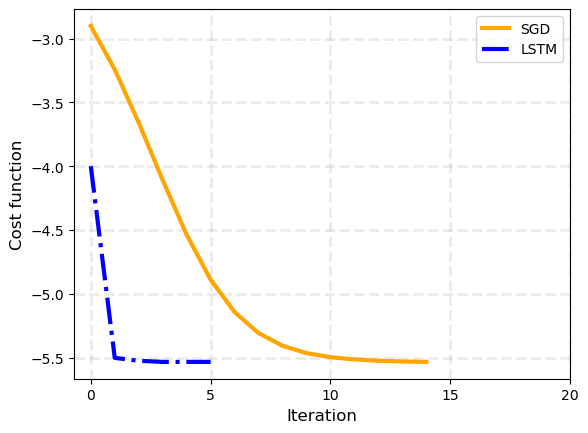

In [85]:
fig, ax = plt.subplots()

plt.plot(sdg_losses, color="orange", lw=3, label="SGD")

plt.plot(lstm_losses, color="blue", lw=3, ls="-.", label="LSTM")

plt.grid(ls="--", lw=2, alpha=0.25)
plt.legend()
plt.ylabel("Cost function", fontsize=12)
plt.xlabel("Iteration", fontsize=12)
ax.set_xticks([0, 5, 10, 15, 20]);
plt.show()

As is clear from the picture, the RNN reaches a better minimum in fewer iterations than the standard SGD. Thus, as the authors suggest, the trained RNN can be used for a few iterations at the start of the training procedure to initialize the parameters of the quantum circuit close to an optimal solution. Then, a standard optimizer like the SGD can be used to fine-tune the proposed parameters and reach even better solutions. While on this small scale example the benefits of using an LSTM to initialize parameters may seem modest, on more complicated instances and problems it can make a big difference, since, on random initialization of the parameters, standard local optimizer may encounter problems finding a good minimization direction

## Final remarks

In this demo, we saw how to use a recurrent neural network as a black-box optimizer to initialize the parameters in a variational quantum circuit close to an optimal solution. We connected MaxCut QAOA quantum circuits in PennyLane with an LSTM built with TensorFlow, and we used a custom hybrid training routine to optimize the whole network.

Such architecture proved itself to be a good candidate for the initialization problem of Variational Quantum Algorithms, since it reaches good optimal solutions in very few iterations. Besides, the architecture is quite general since the same machinery can be used for graphs having a generic number of nodes (see “Generalization Performances” in the Appendix).

## Reference

https://pennylane.ai/qml/demos/learning2learn